In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA


In [2]:
# 2. Load Data
print("Loading data...")
df1 = pd.read_csv('updated_fraud_transactions.csv')
df2 = pd.read_csv('customer_dataset 1.csv')

Loading data...


In [3]:
# Merge transaction and customer data
df = pd.merge(df1, df2, left_on='Sender Account ID', right_on='Customer ID')


In [8]:
df.head()

,Transaction ID,Timestamp,Sender Account ID,Transaction Type,IN_OUT,Amount,Recipient Bank,Fraud,Customer ID,Name,Age,Location,Gender,Account Type,Device Count
0,T00001,2023-08-14 08:37:07,10095,Transfer,In,4887.67,B0004,0,10095,Dilshan De Alwis,59,Batticaloa,Male,Savings,10
1,T00002,2023-12-04 12:54:11,10098,Transfer,In,2371.33,B00010,0,10098,Ruwan Samarasinghe,60,Matara,Male,Savings,10
2,T00003,2023-07-09 23:16:11,10097,Credit,In,4733.44,B0008,0,10097,Sarath Dias,64,Jaffna,Other,Current,8
3,T00004,2023-06-26 07:04:39,10039,Credit,In,1544.12,B0005,0,10039,Nadeeka Dias,60,Kandy,Other,Current,1
4,T00005,2023-09-28 02:40:56,10018,Debit,Out,3978.04,B0004,0,10018,Chathura Hettiarachchi,36,Ratnapura,Other,Savings,4


In [4]:
# Initial data validation checks
print("\nInitial data validation:")
print(df.info())
print(df.isnull().sum())


Initial data validation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Transaction ID     100000 non-null  object 
 1   Timestamp          100000 non-null  object 
 2   Sender Account ID  100000 non-null  int64  
 3   Transaction Type   100000 non-null  object 
 4   IN_OUT             100000 non-null  object 
 5   Amount             100000 non-null  float64
 6   Recipient Bank     100000 non-null  object 
 7   Fraud              100000 non-null  int64  
 8   Customer ID        100000 non-null  int64  
 9   Name               100000 non-null  object 
 10  Age                100000 non-null  int64  
 11  Location           100000 non-null  object 
 12  Gender             100000 non-null  object 
 13  Account Type       100000 non-null  object 
 14  Device Count       100000 non-null  int64  
dtypes: float64(1), int64(5), o

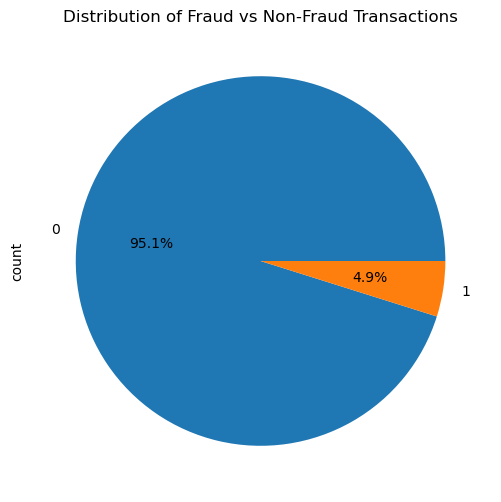

In [5]:
# Fraud Distribution
plt.figure(figsize=(8, 6))
df['Fraud'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

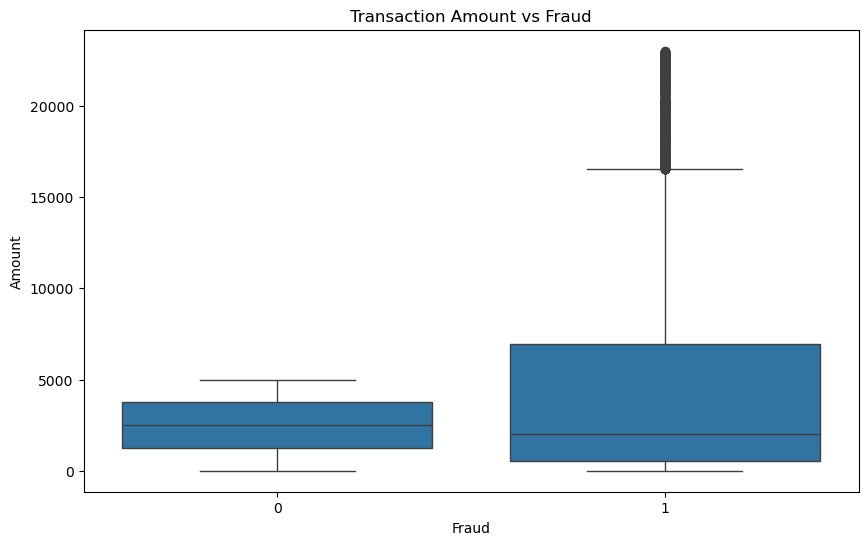

In [6]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=df)
plt.title('Transaction Amount vs Fraud')
plt.show()


In [16]:
# Outlier detection and treatment (example using IQR method for 'Amount')
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Amount'] = np.where(df['Amount'] > upper_bound, upper_bound, df['Amount'])
df['Amount'] = np.where(df['Amount'] < lower_bound, lower_bound, df['Amount'])

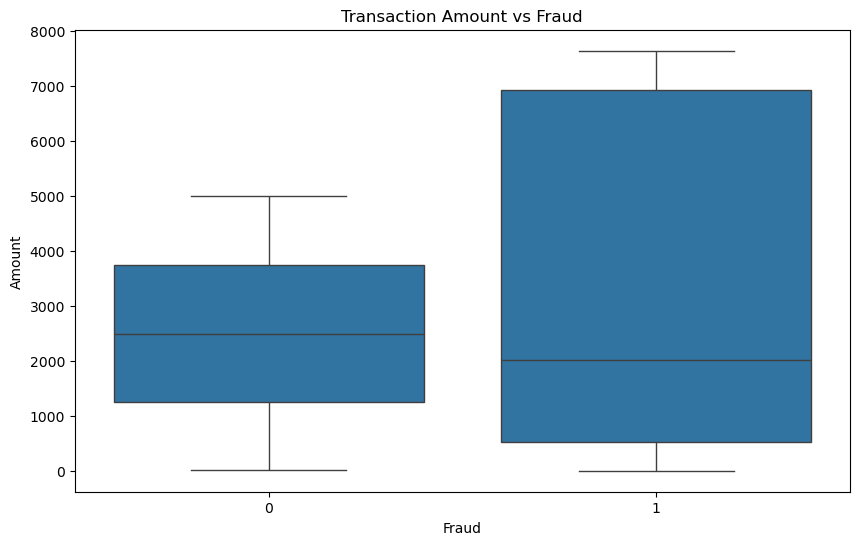

In [17]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=df)
plt.title('Transaction Amount vs Fraud')
plt.show()


In [18]:
# 4. Feature Engineering
print("\nPerforming feature engineering...")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['Amount_Log'] = np.log1p(df['Amount'])


Performing feature engineering...


In [19]:
# Customer behavior features
customer_avg_amount = df.groupby('Sender Account ID')['Amount'].mean().reset_index()
customer_avg_amount.columns = ['Sender Account ID', 'Avg_Amount']
df = pd.merge(df, customer_avg_amount, on='Sender Account ID', how='left')
df['Amount_to_Avg_Ratio'] = df['Amount'] / df['Avg_Amount']

In [20]:
transaction_count = df.groupby('Sender Account ID').size().reset_index(name='Transaction_Count')
df = pd.merge(df, transaction_count, on='Sender Account ID', how='left')


In [21]:
# Prepare features for modeling
categorical_cols = ['Transaction Type', 'IN_OUT', 'Recipient Bank', 'Account Type', 'Gender', 'Location']
numerical_cols = ['Amount', 'Amount_Log', 'Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend',
                  'Avg_Amount', 'Amount_to_Avg_Ratio', 'Transaction_Count', 'Age', 'Device Count']


In [22]:
# One-hot encoding for categorical variables
X = pd.get_dummies(df[categorical_cols + numerical_cols], columns=categorical_cols)
y = df['Fraud']


In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
print("\nClass distribution before SMOTE:")
print(y_train.value_counts(normalize=True))


Class distribution before SMOTE:
Fraud
0    0.951425
1    0.048575
Name: proportion, dtype: float64


In [28]:
# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


In [29]:
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))


Class distribution after SMOTE:
Fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


In [30]:
# 6. Feature Selection
print("\nPerforming feature selection...")
selector = SelectKBest(f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_scaled)



Performing feature selection...


In [31]:
selected_features = X.columns[selector.get_support()].tolist()
print("Top 20 selected features:", selected_features)


Top 20 selected features: ['Amount', 'Hour', 'DayOfWeek', 'IsWeekend', 'Avg_Amount', 'Amount_to_Avg_Ratio', 'Transaction Type_Credit', 'Transaction Type_Transfer', 'Recipient Bank_B0002', 'Recipient Bank_B0004', 'Recipient Bank_B0006', 'Recipient Bank_B0007', 'Recipient Bank_B0008', 'Recipient Bank_B0009', 'Account Type_Current', 'Gender_Female', 'Gender_Other', 'Location_Batticaloa', 'Location_Jaffna', 'Location_Ratnapura']


In [32]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

In [33]:
print(f"Number of components after PCA: {pca.n_components_}")


Number of components after PCA: 16


In [34]:
# 7. Candidate Models
print("\nPreparing candidate models...")
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, 
                          scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                          random_state=42)
svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True, random_state=42)



Preparing candidate models...


In [35]:
# 8. Model Aggregation
print("\nCreating ensemble model...")
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('svm', svm_model)
    ],
    voting='soft'
)


Creating ensemble model...


In [36]:
# 9. Model Evaluation
print("\nEvaluating models...")
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'SVM': svm_model,
    'Ensemble': ensemble_model
}


Evaluating models...


In [38]:
for name, model in models.items():
    model.fit(X_train_pca, y_train_balanced)
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    print(f"\n{name} Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_pca, y_train_balanced, cv=5, scoring='roc_auc')
    print(f"\nCross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     19033
           1       0.15      0.78      0.25       967

    accuracy                           0.78     20000
   macro avg       0.57      0.78      0.56     20000
weighted avg       0.95      0.78      0.84     20000


Confusion Matrix:
[[14783  4250]
 [  208   759]]

ROC AUC Score: 0.8596

Cross-validation ROC AUC: 0.8730 (+/- 0.0063)

Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     19033
           1       0.42      0.67      0.52       967

    accuracy                           0.94     20000
   macro avg       0.70      0.81      0.74     20000
weighted avg       0.96      0.94      0.95     20000


Confusion Matrix:
[[18146   887]
 [  320   647]]

ROC AUC Score: 0.9524

Cross-validation ROC AUC: 0.9938 (+/- 0.0006)

XGB

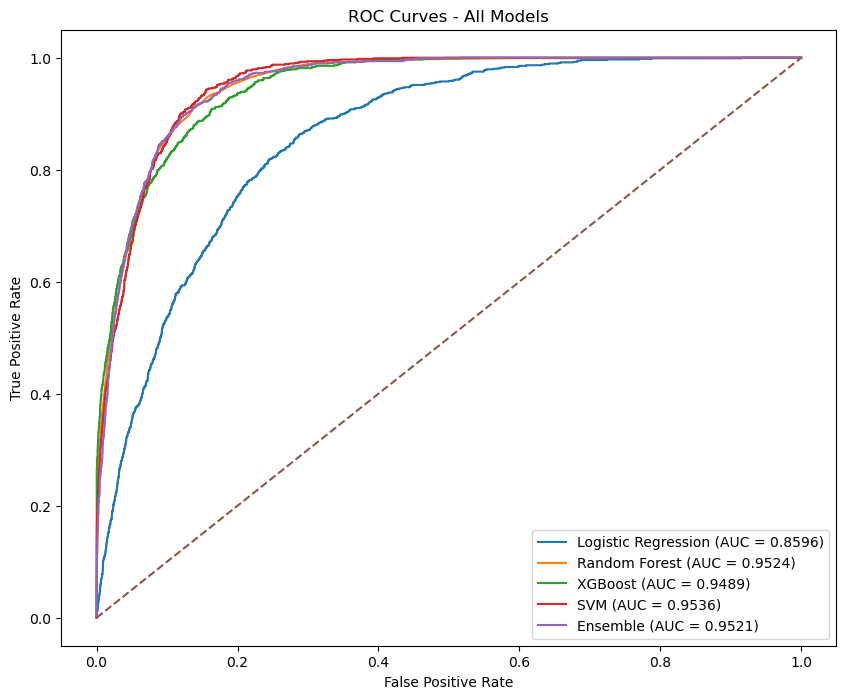

In [39]:
# Compare ROC curves for all models
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend()
plt.show()

In [40]:
# 10. Hyperparameter Tuning
print("\nPerforming hyperparameter tuning...")

# Example for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=3, n_jobs=-1, scoring='roc_auc')
grid_search_rf.fit(X_train_pca, y_train_balanced)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation score:", grid_search_rf.best_score_)



Performing hyperparameter tuning...


KeyboardInterrupt: 

In [ ]:
# Use the best model for final evaluation
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_pca)
y_pred_proba_rf = best_rf_model.predict_proba(X_test_pca)[:, 1]

print("\nBest Random Forest Model Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))
